In [63]:
from pathlib import Path
import numpy as np
import h5py
import scipy.signal
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

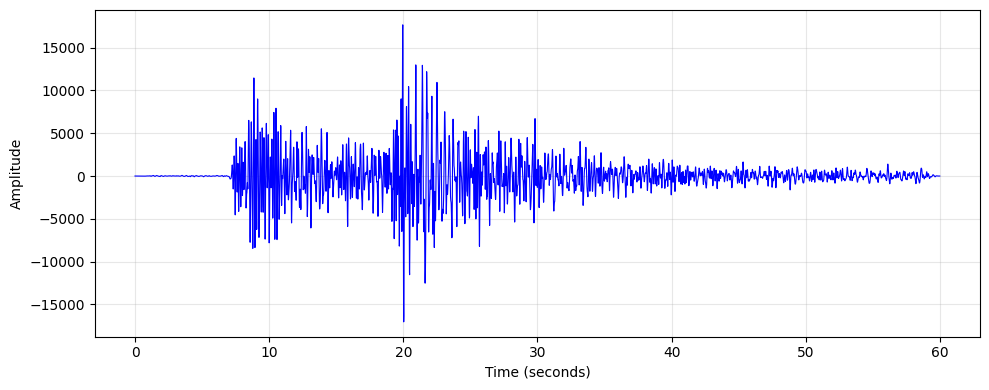

In [85]:
with h5py.File('events_classification_Zonly_TRAIN.h5', "r") as fin:
    waveforms = fin.get('waveforms')[:100]
    event_types = fin.get('type')[:]

event_index = 1
sampling_freq = 100

plt.figure(figsize=(10, 4))
time_axis = np.arange(len(waveforms[event_index, :, 0])) / sampling_freq  # Convert samples to time
plt.plot(time_axis, waveforms[event_index, :, 0], 'b-', linewidth=0.8)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

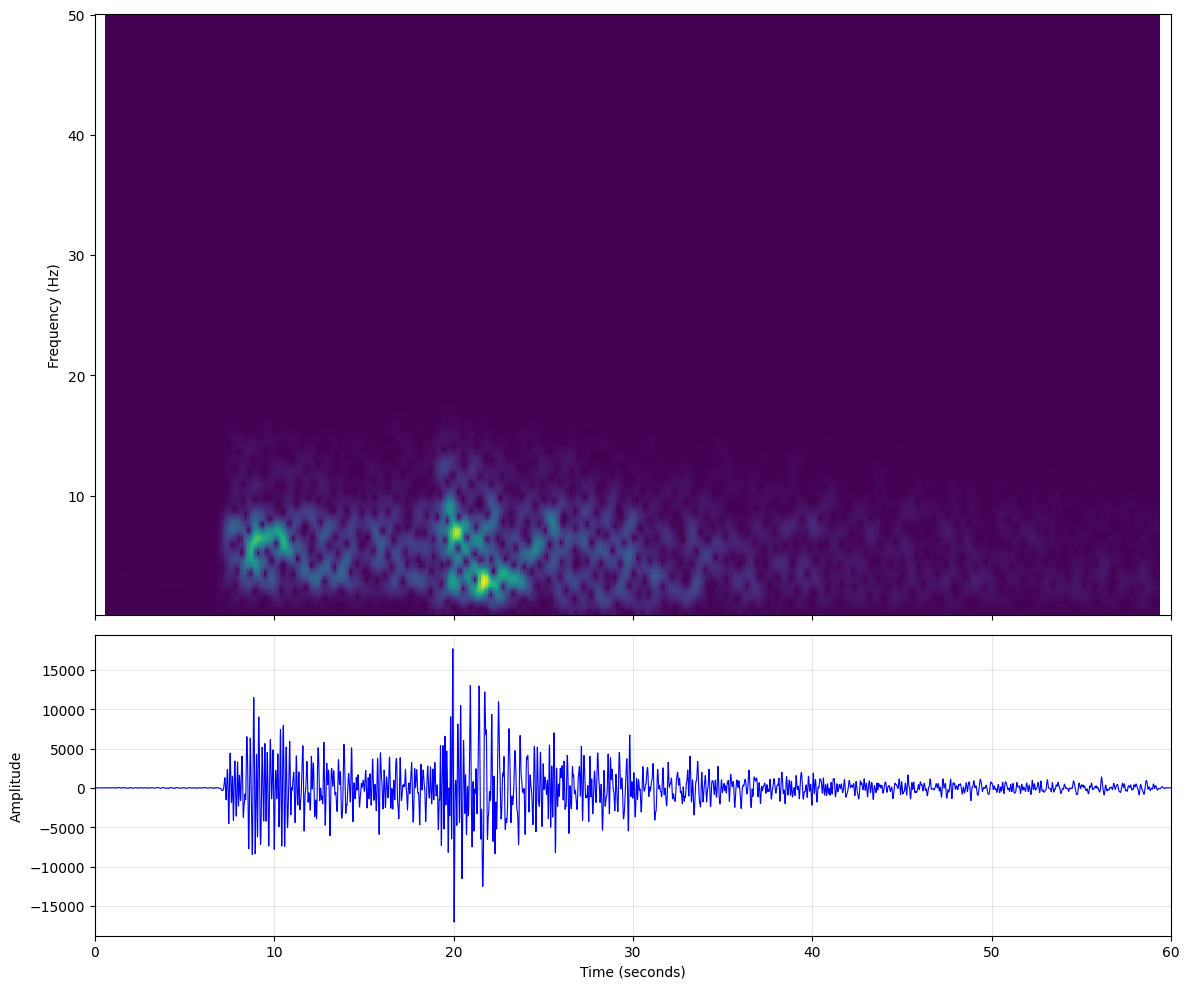

In [86]:
from obspy.imaging.spectrogram import spectrogram 

#fig = spectrogram(waveforms[event_index, :, 0], 100, show=False)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), 
                               gridspec_kw={'height_ratios': [2, 1]}, 
                               sharex=True)

# Top subplot: Spectrogram
ax1.set_ylabel('Frequency (Hz)')
spectrogram(waveforms[event_index, :, 0], sampling_freq, axes=ax1, show=False)


# Bottom subplot: Time series
time_axis = np.arange(len(waveforms[event_index, :, 0])) / sampling_freq  # Convert samples to time
ax2.plot(time_axis, waveforms[event_index, :, 0], 'b-', linewidth=0.8)
ax2.set_xlabel('Time (seconds)')
ax2.set_ylabel('Amplitude')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

"""
for ax in fig.get_axes():
    ax.set_ylim(0, 25)
    ax.set_axis_off()
"""

plt.show()

Function to write spectrograms to file

In [87]:
def write_spectrogram(waveform, fs, filename):

    fig = spectrogram(waveform, fs, show=False)
    for ax in fig.get_axes():
        ax.set_ylim(0.1, 25)
        ax.set_xlim(1, 59)
        ax.set_axis_off()

    fig.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.close()

In [88]:
image_dir = Path('spectrograms')
image_dir.mkdir(exist_ok=True)

for index in range(len(waveforms)):

    if index % 10 == 0:
        print('Computing spectrogram for event', i)

    write_spectrogram(
        waveforms[index, :, 0],
        sampling_freq,
        Path(image_dir / f'event_{index}.png')
    )

Load images 

In [89]:
files = list(image_dir.iterdir())
print(files)

[PosixPath('spectrograms/event_88.png'), PosixPath('spectrograms/event_0.png'), PosixPath('spectrograms/event_71.png'), PosixPath('spectrograms/event_40.png'), PosixPath('spectrograms/event_9.png'), PosixPath('spectrograms/event_8.png'), PosixPath('spectrograms/event_4.png'), PosixPath('spectrograms/event_42.png'), PosixPath('spectrograms/event_30.png'), PosixPath('spectrograms/event_25.png'), PosixPath('spectrograms/event_43.png'), PosixPath('spectrograms/event_32.png'), PosixPath('spectrograms/event_39.png'), PosixPath('spectrograms/event_72.png'), PosixPath('spectrograms/event_21.png'), PosixPath('spectrograms/event_49.png'), PosixPath('spectrograms/event_19.png'), PosixPath('spectrograms/event_90.png'), PosixPath('spectrograms/event_45.png'), PosixPath('spectrograms/event_80.png'), PosixPath('spectrograms/event_68.png'), PosixPath('spectrograms/event_52.png'), PosixPath('spectrograms/event_55.png'), PosixPath('spectrograms/event_62.png'), PosixPath('spectrograms/event_2.png'), Posi

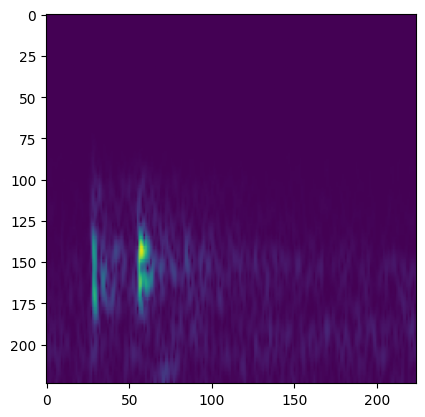

In [90]:
# Show that we can read back the image. 

img = keras.utils.load_img(files[0], target_size=(224, 224))
x = keras.utils.img_to_array(img)
x /= 255.
#x = np.expand_dims(x, axis=0)

plt.imshow(x)

Load a pretrained model and process all images 

In [74]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

In [78]:
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

In [108]:
# Process all the images to extract features

images = []
preds = []
for fin in files:
    img = keras.utils.load_img(fin, target_size=(224, 224))
    x = keras.utils.img_to_array(img)

    images.append(x / 255.)
    
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds.append(
        model.predict(x, verbose=0)
    )

images = np.stack(images, axis=0)
preds = np.vstack(preds)

print('images.shape:', images.shape)
print('preds.shape:', preds.shape)

images.shape: (100, 224, 224, 3)
preds.shape: (100, 2048)


In [82]:
from sklearn.manifold import TSNE

Needs libopenblas-dev 

In [105]:
reducer = TSNE()

embedding = reducer.fit_transform(preds)

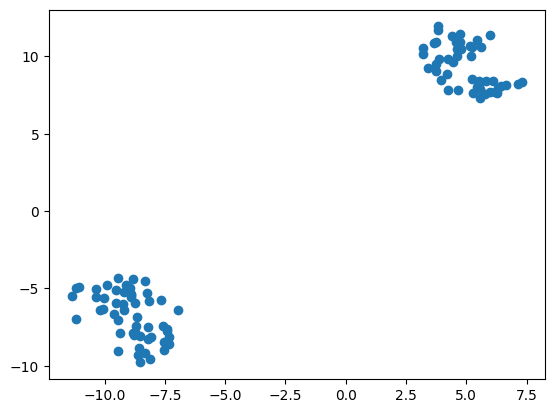

In [106]:
plt.scatter(embedding[:, 0], embedding[:, 1])

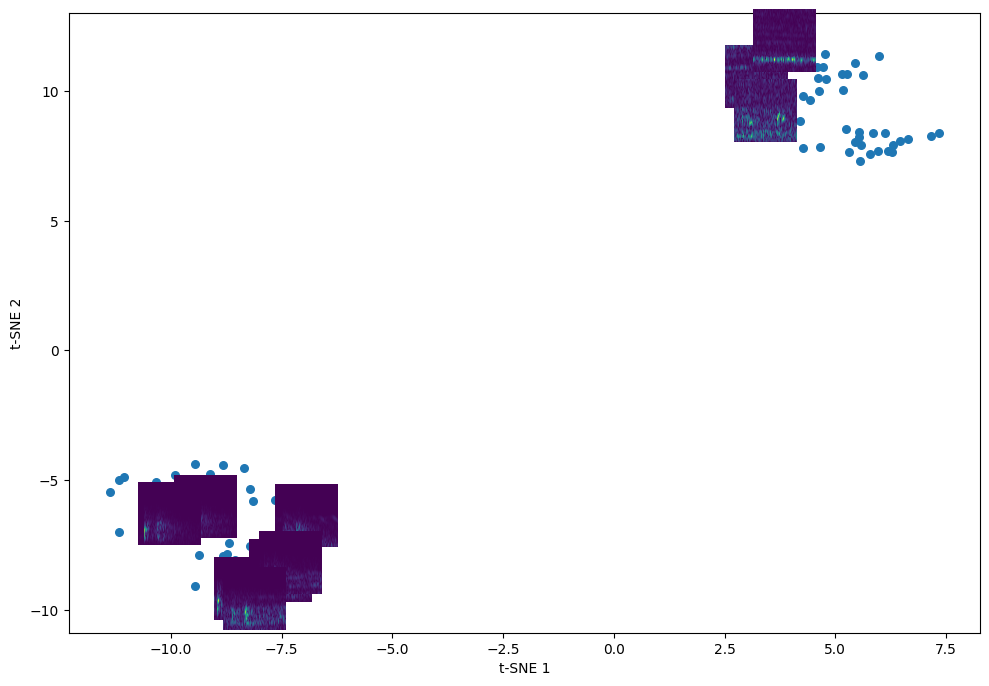

In [115]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_tsne_with_thumbnails(tsne_coords, images, indices_to_show=None, 
                              thumbnail_size=0.2, figsize=(10, 7)):

    
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot all points as scatter plot
    ax.scatter(tsne_coords[:, 0], tsne_coords[:, 1], s=30)
    
    for idx in indices_to_show:
        img = images[idx]
        x, y = tsne_coords[idx]

        imagebox = OffsetImage(img, zoom=thumbnail_size)
        
        ab = AnnotationBbox(imagebox, (x, y), frameon=False, pad=0)
        ax.add_artist(ab)
    
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    
    plt.tight_layout()
    return fig, ax

# Select random indices to show thumbnails
n_thumbnails = 10
indices_to_show = np.random.choice(len(images), n_thumbnails, replace=False)

fig, ax = plot_tsne_with_thumbnails(
    embedding, 
    images, 
    indices_to_show=indices_to_show,
)

plt.show()

In [ ]:
## TODO expand to 3C!